In [1]:
# 필요한 라이브러리 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from data_loader import load_from_gsheet

In [2]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 깨짐 방지

In [3]:
# MAPE 계산 함수
def calculate_mape(y_true, y_pred):
    """
    MAPE (Mean Absolute Percentage Error) 계산
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    nonzero_idx = y_true != 0
    
    
    if not np.any(nonzero_idx):
        return np.inf
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [4]:
# 지수 가중치 함수
def create_exponential_weights(n_samples, decay_rate=0.1):
    """
    최근 데이터에 더 높은 가중치를 주는 지수 가중치 생성
    decay_rate: 가중치 감소 비율 (클수록 최근 데이터에 더 높은 가중치)
    """
    weights = np.exp(-decay_rate * np.arange(n_samples-1, -1, -1))
    return weights / weights.sum() * n_samples  # 평균이 1이 되도록 정규화


In [5]:
# 모델 딕셔너리 정의
def get_models():
    """
    사용할 머신러닝 모델들 정의
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0),
        'LightGBM': LGBMRegressor(random_state=42, verbosity=-1),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5),
        'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    }
    return models


In [6]:
# def load_and_prepare_data(file_path):
#     """
#     데이터 로드 및 시간 맞추기 및 피처 생성
#     """
#     df = pd.read_csv(file_path)
    
#     # 판매일을 datetime으로 변환
#     df['판매일'] = pd.to_datetime(df['판매일'])
    
#     # 데이터를 판매일 순으로 정렬
#     df = df.sort_values('판매일')

#     #Lag & Rolling Feature 생성    
#     df['lag_1'] = df.groupby('상품명')['일별수량'].shift(1)
#     df['lag_7'] = df.groupby('상품명')['일별수량'].shift(7)
    
#     df['roll_mean_3'] = (
#     df.groupby('상품명')['일별수량']
#       .shift(1)  # 바로 전날까지의 데이터만 보고
#       .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
#     )

#     df['roll_mean_7'] = (
#         df.groupby('상품명')['일별수량']
#         .shift(1)
#         .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
#     )
    
#     # NaN 제거
#     df = df.dropna().reset_index(drop=True)
    
#     print(f"전체 데이터 크기: {df.shape}")
#     print(f"메뉴 종류: {df['상품명'].nunique()}개")
#     print(f"데이터 기간: {df['판매일'].min()} ~ {df['판매일'].max()}")
#     print(f"추가된 피처: {[c for c in df.columns if 'lag' in c or 'roll' in c]}")
    
#     return df

In [7]:
def walk_forward_split(data, start_ratio=0.8):
    """
    Walk-forward validation을 위한 train/test 인덱스 생성기
    start_ratio: 처음 학습에 사용할 비율 (예: 0.8 → 전체 중 80%까지 학습 시작)
    """
    n_total = len(data)
    start_idx = int(n_total * start_ratio)
    
    for i in range(start_idx, n_total - 1):
        train_idx = list(range(0, i))     # 처음부터 i-1까지 학습
        test_idx  = [i]                   # i번째를 예측 대상으로 사용
        yield train_idx, test_idx

In [8]:
# 메뉴별 모델 학습 및 평가 (Walk-forward validation 적용)
def train_and_evaluate_models(df, target_col='일별수량'):
    """
    메뉴별로 모든 모델을 Walk-forward validation으로 학습하고 평가
    """
    results = {}
    menu_models = {}
    selected_menus = ['가지솥밥','스테이크솥밥']
    
    # 피처 컬럼 정의 (일별수량과 판매일, 상품명 제외) ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    feature_cols = ['요일_cos','평균기온','평균습도','roll_mean_3', 'roll_mean_7']
    # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    print(f"사용할 피처: {feature_cols}")
    
    # 메뉴 선택 로직
    if selected_menus is None:
        menus = df['상품명'].unique()
    elif isinstance(selected_menus, str):  # 문자열 하나만 들어온 경우
        menus = [selected_menus]
    else:  # 리스트일 경우
        menus = selected_menus

    # 각 메뉴별로 처리
    for menu in menus:
        print(f"\n=== {menu} 모델 학습 중 ===")
        
        # 메뉴별 데이터 필터링
        menu_data = df[df['상품명'] == menu].copy()
        menu_data = menu_data.sort_values('판매일')
        
        if len(menu_data) < 10:  # 데이터가 너무 적으면 스킵
            print(f"{menu}: 데이터가 부족합니다 ({len(menu_data)}개)")
            continue
        
        # 모델들 준비
        models = get_models()

        # 모델별 누적 결과 저장용
        y_true_all = {m: [] for m in models.keys()}
        y_pred_all = {m: [] for m in models.keys()}
        dates_all = []

        # 외부함수로 (walk-forward) train/test 분할 루프
        for train_idx, test_idx in walk_forward_split(menu_data):
            train_data = menu_data.iloc[train_idx]
            test_data  = menu_data.iloc[test_idx]

            X_train = train_data[feature_cols]
            y_train = train_data[target_col]
            X_test = test_data[feature_cols]
            y_test = test_data[target_col]
        
            # 지수 가중치 생성
            sample_weights = create_exponential_weights(len(X_train))
        
            # 피처 스케일링
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            # 각 모델 학습 및 예측
            for model_name, model in models.items():
                try:
                    # 가중치를 지원하는 모델
                    if hasattr(model, 'fit') and 'sample_weight' in model.fit.__code__.co_varnames:
                        if model_name in ['SVR', 'MLP']:
                            model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
                            y_pred = model.predict(X_test_scaled)
                        else:
                            model.fit(X_train, y_train, sample_weight=sample_weights)
                            y_pred = model.predict(X_test)
                    else:
                        # 가중치 미지원 모델
                        if model_name in ['SVR', 'MLP']:
                            model.fit(X_train_scaled, y_train)
                            y_pred = model.predict(X_test_scaled)
                        else:
                            model.fit(X_train, y_train)
                            y_pred = model.predict(X_test)
                    
                    # 결과 누적
                    y_true_all[model_name].append(y_test.values[0])
                    y_pred_all[model_name].append(y_pred[0])
                    
                except Exception as e:
                    print(f"  {model_name}: 학습 실패 - {e}")
                    continue
            
            # 날짜 저장 (모든 모델 동일)
            dates_all.append(test_data['판매일'].values[0])
        
        # 루프 종료 후 모델별 성능 계산
        menu_results = {}
        for model_name in models.keys():
            y_true_arr = np.array(y_true_all[model_name])
            y_pred_arr = np.array(y_pred_all[model_name])
            
            if len(y_true_arr) == 0:  # 실패한 모델은 스킵
                continue
            
            rmse = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))
            mape = calculate_mape(y_true_arr, y_pred_arr)
            
            menu_results[model_name] = {
                'RMSE': rmse,
                'MAPE': mape,
                'y_true': y_true_arr,
                'y_pred': y_pred_arr,
                'dates': np.array(dates_all),
                'model': models[model_name],
                'scaler': scaler  # 스케일러도 저장 
            }
            
            print(f"  {model_name}: RMSE={rmse:.4f}, MAPE={mape:.2f}%")
        
        # 베이스 모델 선정 (MASE 기준)
        if menu_results:
            best_model = min(menu_results.keys(), key=lambda x: menu_results[x]['MAPE'])
            menu_results['best_model'] = best_model
            print(f"  베이스 모델: {best_model}")
            
            results[menu] = menu_results
            menu_models[menu] = menu_results[best_model]
    
    return results, menu_models, feature_cols


In [9]:
# 결과 시각화
def visualize_results(results):
    """
    메뉴별 모델 성능 및 예측 결과 시각화
    """
    n_menus = len(results)
    if n_menus == 0:
        print("시각화할 결과가 없습니다.")
        return
    
    # 각 메뉴별로 개별 시각화
    for i, (menu, menu_results) in enumerate(results.items()):
        if 'best_model' not in menu_results:
            continue
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{menu} - 모델 성능 분석', fontsize=16, fontweight='bold')
        
        # 1. RMSE 비교
        models = [k for k in menu_results.keys() if k != 'best_model']
        rmse_values = [menu_results[k]['RMSE'] for k in models]
        
        bars1 = ax1.bar(range(len(models)), rmse_values, color='skyblue', alpha=0.7)
        ax1.set_xlabel('모델')
        ax1.set_ylabel('RMSE')
        ax1.set_title('RMSE 비교')
        ax1.set_xticks(range(len(models)))
        ax1.set_xticklabels(models, rotation=45, ha='right')
        
        # 베이스 모델 하이라이트
        best_idx = models.index(menu_results['best_model'])
        bars1[best_idx].set_color('orange')
        
        # 2. MAPE 비교
        mape_values = [menu_results[k]['MAPE'] for k in models]
        bars2 = ax2.bar(range(len(models)), mape_values, color='lightgreen', alpha=0.7)
        ax2.set_xlabel('모델')
        ax2.set_ylabel('MAPE (%)')
        ax2.set_title('MAPE 비교')
        ax2.set_xticks(range(len(models)))
        ax2.set_xticklabels(models, rotation=45, ha='right')
        
        # 베이스 모델 하이라이트
        bars2[best_idx].set_color('red')
        
        # 3. 예측 vs 실제값 비교 (선그래프로 변경)
        ax3.set_title('실제값 vs 예측값 (시계열)')
        ax3.set_xlabel('날짜')
        ax3.set_ylabel('일별수량')

        # x축 = 테스트 구간 날짜 (모든 모델 동일하므로 첫 모델 기준)
        dates = menu_results[models[0]]['dates']
        
        # 실제값 (검은 굵은 선)
        actual = menu_results[models[0]]['y_true']
        ax3.plot(dates, actual, label='Actual', color='black', linewidth=2)
        
        # 모델별 예측
        best_model_name = menu_results['best_model']
        for model_name in models:
            preds = menu_results[model_name]['y_pred']
            if model_name == best_model_name:
                ax3.plot(dates, preds, label=f"{model_name} (Best)", 
                        color='red', linewidth=2.5)  # 굵고 빨간색
            else:
                ax3.plot(dates, preds, label=model_name, linewidth=1, alpha=0.7)  # 얇고 연한 선
        
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. 베이스 모델 상세 정보
        best_model_name = menu_results['best_model']
        best_results = menu_results[best_model_name]
        
        ax4.text(0.1, 0.8, f'베이스 모델: {best_model_name}', fontsize=14, fontweight='bold')
        ax4.text(0.1, 0.6, f'RMSE: {best_results["RMSE"]:.4f}', fontsize=12)
        ax4.text(0.1, 0.4, f'MAPE: {best_results["MAPE"]:.2f}%', fontsize=12)
        ax4.text(0.1, 0.2, f'실제 마지막값: {best_results["y_true"][-1]:.2f}', fontsize=12)
        ax4.text(0.1, 0.0, f'예측 마지막값: {best_results["y_pred"][-1]:.2f}', fontsize=12)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')
        
        plt.tight_layout()
        plt.show()

In [10]:
# 전체 성능 요약
def summary_results(results):
    """
    전체 결과 요약
    """
    if not results:
        print("분석할 결과가 없습니다.")
        return
    
    print("\n" + "="*80)
    print("전체 결과 요약")
    print("="*80)
    
    summary_data = []
    for menu, menu_results in results.items():
        if 'best_model' not in menu_results:
            continue
            
        best_model_name = menu_results['best_model']
        best_results = menu_results[best_model_name]
        
        summary_data.append({
            '메뉴': menu,
            '베이스_모델': best_model_name,
            'RMSE': best_results['RMSE'],
            'MAPE(%)': best_results['MAPE'],
            '실제값': best_results['y_true'][-1],
            '예측값': best_results['y_pred'][-1],
            # '오차율(%)': abs(best_results['y_true'] - best_results['y_pred']) / best_results['y_true'] * 100
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.round(4)
    
    print(summary_df.to_string(index=False))
    
    # 전체 평균 성능
    print(f"\n평균 RMSE: {summary_df['RMSE'].mean():.4f}")
    print(f"평균 MAPE: {summary_df['MAPE(%)'].mean():.2f}%")
    # print(f"평균 오차율: {summary_df['오차율(%)'].mean():.2f}%")
    
    # 모델별 선택 빈도
    model_counts = summary_df['베이스_모델'].value_counts()
    print(f"\n베이스 모델 선택 빈도:")
    for model, count in model_counts.items():
        print(f"  {model}: {count}회")

음식점 매출 예측 베이스 모델 구축을 시작합니다!
전체 데이터 크기: (4380, 24)
메뉴 종류: 14개
데이터 기간: 2024-08-30 00:00:00 ~ 2025-08-31 00:00:00
추가된 피처: ['lag_1', 'lag_7', 'roll_mean_3', 'roll_mean_7', 'roll_std_3', 'roll_std_7']
사용할 피처: ['요일_cos', '평균기온', '평균습도', 'roll_mean_3', 'roll_mean_7']

=== 가지솥밥 모델 학습 중 ===
  Linear Regression: RMSE=6.6398, MAPE=26.84%
  Ridge: RMSE=6.6397, MAPE=26.84%
  Lasso: RMSE=6.6847, MAPE=27.35%
  ElasticNet: RMSE=6.6465, MAPE=27.12%
  Decision Tree: RMSE=9.4463, MAPE=34.01%
  Random Forest: RMSE=6.5472, MAPE=25.18%
  Extra Trees: RMSE=6.3320, MAPE=24.56%
  Gradient Boosting: RMSE=6.5215, MAPE=24.70%
  XGBoost: RMSE=7.1689, MAPE=27.28%
  LightGBM: RMSE=6.8598, MAPE=25.55%
  SVR: RMSE=6.2369, MAPE=25.63%
  KNN: RMSE=6.4388, MAPE=24.44%
  MLP: RMSE=6.1307, MAPE=23.03%
  베이스 모델: MLP

=== 스테이크솥밥 모델 학습 중 ===
  Linear Regression: RMSE=6.6367, MAPE=23.88%
  Ridge: RMSE=6.6367, MAPE=23.88%
  Lasso: RMSE=6.6060, MAPE=23.80%
  ElasticNet: RMSE=6.6186, MAPE=23.83%
  Decision Tree: RMSE=9.7292, MAPE

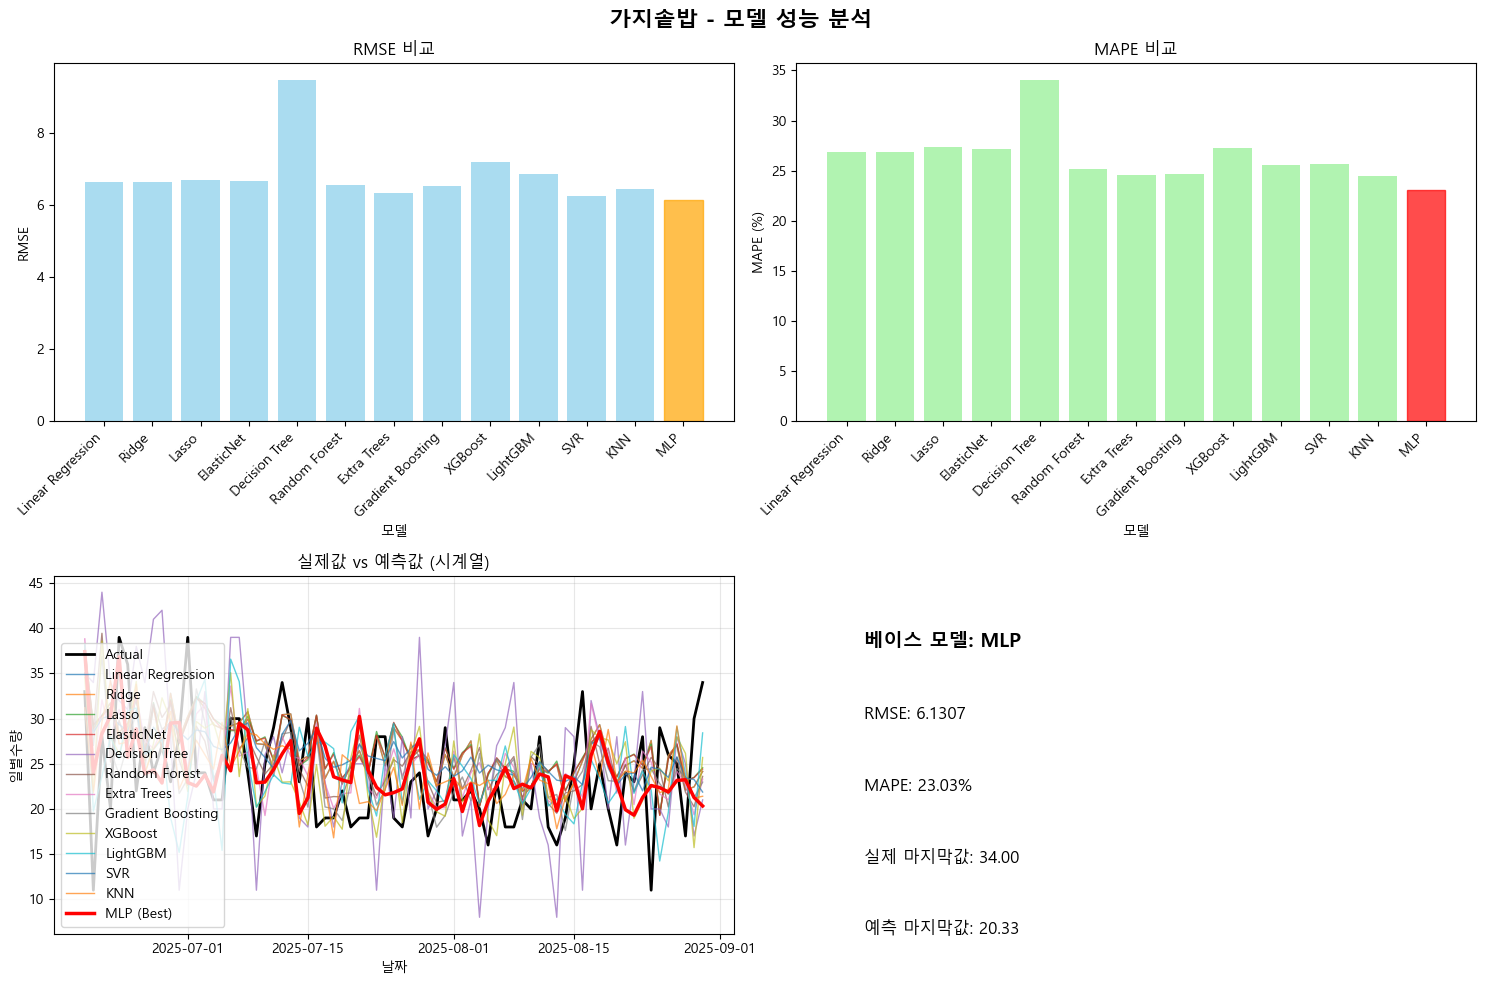

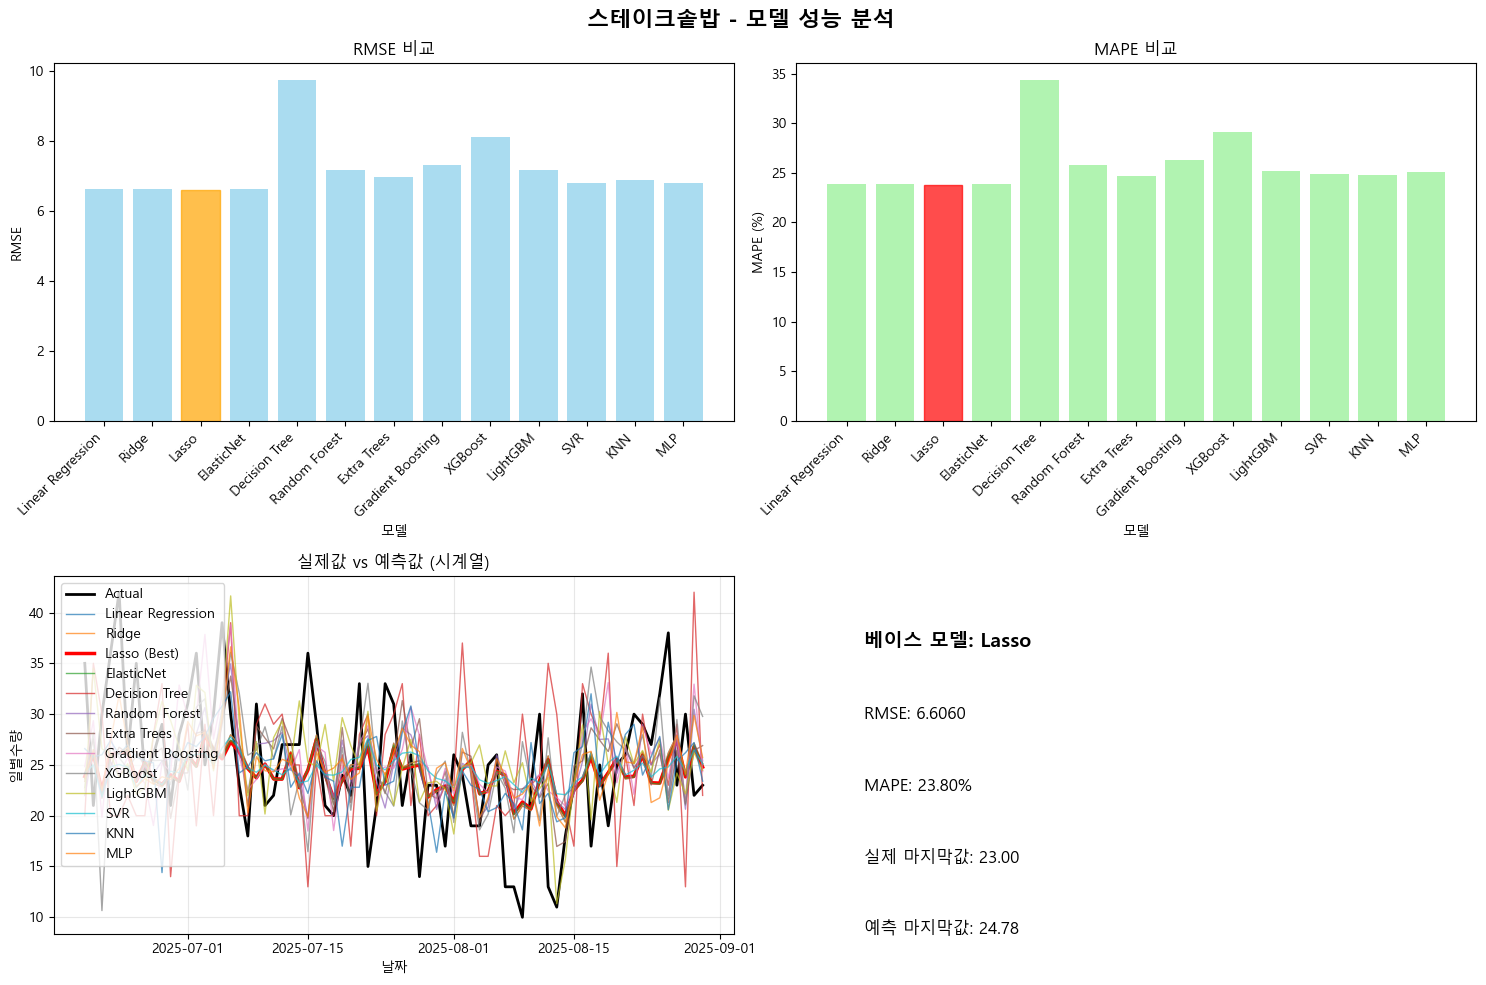


전체 결과 요약
    메뉴 베이스_모델   RMSE  MAPE(%)  실제값     예측값
  가지솥밥    MLP 6.1307  23.0307   34 20.3273
스테이크솥밥  Lasso 6.6060  23.8046   23 24.7850

평균 RMSE: 6.3683
평균 MAPE: 23.42%

베이스 모델 선택 빈도:
  MLP: 1회
  Lasso: 1회
['요일_cos', '평균기온', '평균습도', 'roll_mean_3', 'roll_mean_7']

분석이 완료되었습니다!
각 메뉴별 베스트 모델이 선정되었으며, 결과가 시각화되었습니다.


In [11]:
# 메인 실행 함수
def main():
    """
    전체 분석 파이프라인 실행
    """
    print("음식점 매출 예측 베이스 모델 구축을 시작합니다!")
    
    # 1. 데이터 로드
    df = load_from_gsheet()
    
    # 2. 모델 학습 및 평가
    results, menu_models, feature_cols = train_and_evaluate_models(df)
    
    # 3. 결과 시각화
    visualize_results(results)
    
    # 4. 결과 요약
    summary_results(results)
    print(feature_cols)
    
    return results, menu_models

# 사용 예시
if __name__ == "__main__":
    # 분석 실행
    results, models = main()
    
    print("\n분석이 완료되었습니다!")
    print("각 메뉴별 베스트 모델이 선정되었으며, 결과가 시각화되었습니다.")